<a href="https://colab.research.google.com/github/boqchen/Mathematical-Foundations-of-Computer-Graphics-and-Vision---SS21/blob/main/MF2021_Exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MathFound - EXERCISE 3 - MLS FOR CURVES, MESHES AND IMAGES
## General Rules

**Plagiarism note.** Copying code (either from other students or from external sources) is strictly prohibited! We will be using automatic anti-plagiarism tools, and any violation of this rule will lead to expulsion from the class.

Late submissions will not be accepted, except in case of serious illness or emergency. In that case please notify the assistants and provide a relevant medical certificate.

**Software.** All exercises of this course use Python.

**What to hand in.** Upload a .zip file of your solution in Moodle. The file must be called `MATHFOUND21-3-firstname-familyname.zip`. The `.zip` file MUST contain the following data inside:

* A jupyter notebook with the solution to the exercise and a description of what you implemented and comments/explanations on your results.

**OR** 

* The solution in `.py` format and a `readme.pdf` file containing a description of what you’ve implemented and instructions for running it, as well as explanations/comments on your results.

**Grading** This homework is 8.3% of your final grade. Your submission will be graded according to the quality of the images produced by your program, the conformance of your program to the expected behaviour of the assignment, and your understanding of the underlying techniques used in the assignment. The submitted code must produce exactly the same images included in your submission.

## Goal of this exercise

In this exercise you will apply what you learned about the Moving Least Squares (MLS) method to curves, meshes and images. You will read and implement parts of research papers that used MLS.

## Image deformation using MLS

The first task of this assignment is to write code which deforms images based on moving least squares as presented in the paper "Image Deformation using Moving Least Squares" by Schaefer et al. (provided with the exercise). In this paper, the authors propose a method to smoothly deform images using different kinds of transformations and allow the user to manipulate sets of points and segments to specify the deformations. For this exercise you will only focus on image deformations using sets of points.

Write a program which takes as input an image, some input and out control points and performs the deformation. The algorithm should follow the description from the paper. The three kinds of transformation, i.e. affine, similarity and rigid transformations should be supported by your program. Please note that we don't ask for an interactive application so that you don't need to worry about making the code fast (precomputation of some terms, approximation of the image by a grid), but you can do it if you wish.

Some pointers to help with your implementation:

* Read section 2 of the paper to understand the types of transformations you need to apply.
* Implement backwards warping to avoid artifacts.
* You can use `meshgrid` (in `numpy`) and `griddata` (in `scipy`) functions to implement the warping process

Your result should ressemble the following

![](https://drive.google.com/uc?export=view&id=1_Y4UdS8d3io-OiSSDtyopwPZ_CFF11-r)

### Required output

* **Code that deforms images according to user input using all three methods described above (affine, similarity and rigid).**
* **Representative image results of the gingerbread man (provided with the exercise) and at least one more image of your choice.**

### Selecting the control points interactively

If you want to create an interactive version of your image deformation code, you can look into using `ipywidgets` which allows you to set a callback function when the user clicks on the displayed image (with matplotlib). Any other solution is also fine (for example if you want to make a standalone `.py` for that part :).

In [ ]:
! pip install numpy

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
import cv2
import os
import warnings

In [16]:
class Transform(object):

  def __init__(self, p, q, img_h, img_w, alpha):

    # """args: 
    #       p: selected control points
    #       q: deformed control points
    #       img_h: height of the input image 
    #       img_w: width of the input image 
    #       alpha: alpha-value of the weight 
    # """
    self.p = p
    self.q = q
    self.img_h = img_h
    self.img_w = img_w
    self.alpha = alpha

  def rigid_transform(self):

    fr_v_array = np.zeros((self.img_h, self.img_w, 2))

    # number of control points
    n = self.p.shape[0]

    for vx in range(self.img_w):
        for vy in range(self.img_h):
            
            # v point from image
            v = np.array([[vx, vy]])

            sqd_pi_v = distance_matrix(self.p ,v) ** 2
            w = 1 / (sqd_pi_v ** self.alpha)

            # calculate p_star and q_star
            # w is column vector
            p_star = np.dot(w.T, self.p) / np.sum(w)
            q_star = np.dot(w.T, self.q) / np.sum(w)

            p_hat = self.p - p_star
            q_hat = self.q - q_star

            # calculate Ai
            p_hat_orth = np.stack([-p_hat[:, 1], p_hat[:, 0]], 1)
            v_p_star = v - p_star
            v_p_star_orth = np.stack([-v_p_star[:, 1], v_p_star[:, 0]], 1)

            # fr(v) = sigma_i (sigma_term) + q_star
            sigma_term = np.zeros((n, 2))

            for i in range(n):
                # calculate Ai
                Ai = w[i] * \
                    np.dot(
                        np.stack([p_hat[i, :], -p_hat_orth[i, :]], 0), 
                        np.concatenate([v_p_star, -v_p_star_orth], 0).T
                        )

                # sigma_term
                sigma_term[i, :] = np.dot(q_hat[i, :], Ai)

            fr_v_vector = np.sum(sigma_term, 0);
            fr_v = np.linalg.norm(v - p_star) * fr_v_vector / np.linalg.norm(fr_v_vector) + q_star;
            fr_v = np.round(fr_v)

            fr_v_array[vy, vx, 0] = fr_v[0][0]
            fr_v_array[vy, vx, 1] = fr_v[0][1]
    

    return fr_v_array



  def similar_transform(self):

    fs_v_array = np.zeros((self.img_h, self.img_w, 2))

    # number of control points
    n = self.p.shape[0]

    for vx in range(self.img_w):
        for vy in range(self.img_h):

            # v point from image
            v = np.array([[vx, vy]])

            sqd_pi_v = distance_matrix(self.p ,v) ** 2
            w = 1 / (sqd_pi_v ** self.alpha)

            # calculate p_star and q_star
            # w is column vector
            p_star = np.dot(w.T, self.p) / np.sum(w)
            q_star = np.dot(w.T, self.q) / np.sum(w)

            p_hat = self.p - p_star
            q_hat = self.q - q_star

            # calculate mu_s 
            mu_s_i = np.zeros((n, 1))

            for i in range(n):
                  mu_s_i[i] = w[i] * np.dot(p_hat[i], p_hat[i].T)
                
            mu_s = np.sum(mu_s_i)

            # calculate Ai and fs(v)   
            p_hat_orth = np.stack([-p_hat[:, 1], p_hat[:, 0]], 1)
            v_p_star = v - p_star
            v_p_star_orth = np.stack([-v_p_star[:, 1], v_p_star[:, 0]], 1)

            #fs(v) = sigma_i (sigma_term) + q_star
            sigma_term = np.zeros((n, 2))

            for i in range(n):
                # calculate Ai
                Ai = w[i] * \
                    np.dot(
                        np.stack([p_hat[i, :], -p_hat_orth[i, :]], 0), 
                        np.concatenate([v_p_star, -v_p_star_orth], 0).T
                        )
                sigma_term[i, :] = np.dot(q_hat[i, :], (1/mu_s * Ai))
            
            fs_v = np.sum(sigma_term, 0) + q_star
            
            # round fs(v)
            fs_v = np.round(fs_v)

            fs_v_array[vy, vx, 0] = fs_v[0][0]
            fs_v_array[vy, vx, 1] = fs_v[0][1]
    

    return fs_v_array


  def affine_transform(self):

    fa_v_array = np.zeros((self.img_h, self.img_w, 2))

    # number of control points
    n = self.p.shape[0]

    for vx in range(self.img_w):
        for vy in range(self.img_h):
            
            # v point from image
            v = np.array([[vx, vy]])
            sqd_pi_v = distance_matrix(self.p ,v) ** 2
            w = 1 / (sqd_pi_v ** self.alpha)

            # calculate p_star and q_star
            # w is column vector
            p_star = np.dot(w.T, self.p) / np.sum(w)
            q_star = np.dot(w.T, self.q) / np.sum(w)

            # sigma i term: sum(p_hat_i' * w_i * p_hat_i)
            sum_phatT_w_phat = np.zeros((2, 2))

            for i in range(n):
                p_hat_i = np.expand_dims(self.p[i], 0) - p_star
                sum_phatT_w_phat += np.dot(p_hat_i.T * w[i][0], p_hat_i)
            
            # calculate Aj
            Aj = np.zeros((n, 1))

            for j in range(n):
                # Aj is single scalar
                Aj[j] = np.dot(
                    (v - p_star), 
                    np.dot(np.linalg.inv(sum_phatT_w_phat), (w[j][0] * np.expand_dims(self.p[j], 0).T))
                    )
            
            fa_v = np.sum(Aj * (self.q - q_star), 0) + q_star
            fa_v = np.round(fa_v)

            fa_v_array[vy, vx, 0] = fa_v[0][0]
            fa_v_array[vy, vx, 1] = fa_v[0][1]
    
    
    return fa_v_array
  

In [17]:
def backwardwarp(f_v_array, img):
    
    img_h, img_w, _ = img.shape

    # create grid points, i.e., query points for v'
    xq, yq = np.meshgrid(np.arange(img_w), np.arange(img_h))

    f_v_array_x = f_v_array[:, :, 0]
    f_v_array_y = f_v_array[:, :, 1]

    # filtering nan values (created by singular cases)
    # TODO np.inf is not checked
    vx = xq[~np.isnan(f_v_array_x)]
    vy = yq[~np.isnan(f_v_array_y)]

    f_v_array_x = f_v_array_x[~np.isnan(f_v_array_x)]
    f_v_array_y = f_v_array_y[~np.isnan(f_v_array_y)]

    # regression f_inv function and get v = f_inv([vx, vy])
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    v_q_x = griddata(
        np.stack([f_v_array_x, f_v_array_y], 1),
        vx, 
        np.stack([xq, yq], 1),
        method='nearest'
        )
    v_q_y = griddata(
        np.stack([f_v_array_x, f_v_array_y], 1),
        vy, 
        np.stack([xq, yq], 1),
        method='nearest'
        )

    # backward warping
    deformed_img = np.zeros(img.shape)

    for i in range(xq.shape[0]):
        # v'
        v_dash = [xq[i], yq[i]]

        # v = f_inv(v')
        inversed_v = [v_q_x[i], v_q_y[i]]
        inversed_v = np.round(inversed_v)    # round v

        if inversed_v[0] > 0 and inversed_v[1] > 0 and \
                inversed_v[0] < img.shape[1] and inversed_v[1] < img.shape[0]:
            # check bound
            deformed_img[v_dash[1], v_dash[0], :] = img[inversed_v[1], inversed_v[0], :]

    
    deformed_img = deformed_img.astype(np.uint8)
    return deformed_img

In [25]:
warnings.filterwarnings("ignore")

P = np.array(
    [[36, 159],
    [178, 155],
    [311, 161],
    [125, 295],
    [228, 288],
    [116, 369],
    [259, 382]]
    )

Q = np.array(
    [[35, 245],
    [163, 165],
    [305, 78],
    [80, 301],
    [196, 306],
    [159, 379],
    [290, 382]]
    )

def main():
    img = cv2.imread('data/ginger.png')[:,:,::-1]
    img_h, img_w = img.shape[:2]
    alpha = 3

    transform = Transform(P, Q, img_h, img_w, alpha)
    
    affine = transform.affine_transform()
    similar = transform.similar_transform()
    rigid = transform.rigid_transform()

    affine_backward = backwardwarp(affine, img)
    similar_backward = backwardwarp(similar, img)
    rigid_backward = backwardwarp(rigid, img)
    
    os.makedirs('result', exist_ok=True)
    cv2.imwrite(os.path.join('result', 'affine_ginger_3.png'), affine_backward[:,:,::-1])
    cv2.imwrite(os.path.join('result', 'similar_ginger_3.png'), similar_backward[:,:,::-1])
    cv2.imwrite(os.path.join('result', 'rigid_ginger_3.png'), rigid_backward[:,:,::-1])

if __name__ == '__main__':
    main()

In [22]:
def main():
    img = cv2.imread('data/stitch.png')[:,:,::-1]
    img_h, img_w = img.shape[:2]
    alpha = 1.0

    transform = Transform(P, Q, img_h, img_w, alpha)
    
    affine = transform.affine_transform()
    similar = transform.similar_transform()
    rigid = transform.rigid_transform()

    affine_backward = backwardwarp(affine, img)
    similar_backward = backwardwarp(similar, img)
    rigid_backward = backwardwarp(rigid, img)
    
    os.makedirs('result', exist_ok=True)
    cv2.imwrite(os.path.join('result', 'affine_stitch_bw.png'), affine_backward[:,:,::-1])
    cv2.imwrite(os.path.join('result', 'similar_stitch_bw.png'), similar_backward[:,:,::-1])
    cv2.imwrite(os.path.join('result', 'rigid_stitch_bw.png'), rigid_backward[:,:,::-1])

if __name__ == '__main__':
    main()

### Results


> Ginger

The following figures shows the original version, affine, similar, rigid transformation of the ginger man when $\alpha=1$.

| ![](https://drive.google.com/uc?export=view&id=1fCqTHFSk0rEmBIbabWwdabFIQSIUJoW4)| | ![](https://drive.google.com/uc?export=view&id=1paJZuqrmV0EjJhdDIA6qq0Zs5Jj8ACbI)| | ![](https://drive.google.com/uc?export=view&id=1JCs-zZ0W2DJyxYROdzzupr1qreMK1zwx)| | ![](https://drive.google.com/uc?export=view&id=1LpNQ5eN4-XXhLF22vKXfZPYMVq776HP0)| 
|:--:| |:--:| |:--:| |:--:| 
| *original* || *affine* || *similar* || *rigid* |




The following figures shows the original version, affine, similar, rigid transformation of the ginger man when $\alpha=0.5$.

| ![](https://drive.google.com/uc?export=view&id=1fCqTHFSk0rEmBIbabWwdabFIQSIUJoW4)| | ![](https://drive.google.com/uc?export=view&id=17SI2UbA1l6nmQIMW_kSVZztQa-NiHDWV)| | ![](https://drive.google.com/uc?export=view&id=15-z4MW7BA6vavPRu9kRvmIUdCFCJJk8e)| | ![](https://drive.google.com/uc?export=view&id=1Vhm5yoXFGUZx0_9B66ljG6udopLk4fuA)| 
|:--:| |:--:||:--:| |:--:|  
| *original* || *affine* || *similar* || *rigid* |


The following figures shows the original version, affine, similar, rigid transformation of the ginger man when $\alpha=3$.

| ![](https://drive.google.com/uc?export=view&id=1fCqTHFSk0rEmBIbabWwdabFIQSIUJoW4)| | ![](https://drive.google.com/uc?export=view&id=1QjycVd49WLB9UVhgwEUjgi8fridSaifE)|| ![](https://drive.google.com/uc?export=view&id=1G_tC9F7Q7qoB2gxQqBQbwg-dbasf3glW)| | ![](https://drive.google.com/uc?export=view&id=11NhKFQ0wPIZUrjNrFRFo1FhTtZ0O3A5J)|
|:--:| |:--:||:--:| |:--:|  
| *original* || *affine* || *similar* || *rigid* |  

> Stitch

The following figures shows the original version, affine, similar, rigid transformation of the Stitch when $\alpha=1$.

| ![](https://drive.google.com/uc?export=view&id=1baWYZUzyTbKIH7af2KgZqnzwCttmDfM6)| | ![](https://drive.google.com/uc?export=view&id=1Qc-MDh5CRL0bRivand3IEgh806scfxOF)|| ![](https://drive.google.com/uc?export=view&id=1vd4nAMAe08p47LrfbBOcYjSR1w91YnrJ)| | ![](https://drive.google.com/uc?export=view&id=1ScJThpwD5MjGEPl85mx3WXhg9YJvkVqz)|  
|:--:| |:--:||:--:| |:--:|  
| *original* || *affine* || *similar* || *rigid* |










### Discussion

As is shown in the results, increasing $\alpha$ will make control points follow deformed points more. Also, affine overall gives comparably better results. 

## Curve and Surface Reconstruction Using MLS

As described in the lectures, moving least squares (MLS) can be used to approximate a function given samples from that function at sample points. In this exercise, we will utilize this method to reconstruct curves and smooth meshes. We provide a few example datasets.

### Implicit MLS Surfaces

Given some samples points and attributes (i.e. normals, colors), we seek to find a function $f(\mathbf{x}) : \mathbb{R}^2 \text{ or } \mathbb{R}^3 \rightarrow \mathbb{R}$ such that the curve or surface is given by $\mathcal{S} = \{ \mathbf{x} \vert f(\mathbf{x}) = 0, \nabla f(\mathbf{x}) \neq \mathbf{0} \}$

### Curves derivation

MLS based surfaces can be computed by considering different degrees for the local approximations and constraints, as described in the lectures. The first part of the exercise is to derive on paper one of the simplest definitions for MLS based surfaces. For this task, we assume that the locally fit polynomial consists of a single constant term, $f(\mathbf{x}) = c_0$,

$$
\underset{c_0}{\operatorname{argmin}}\sum_i \phi_i(\mathbf{x})(c_0 - f_i(\mathbf{x}))^2
$$

Using the following local functional approximation

$$
f_i(\mathbf{x}) = \mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})
$$

**derive the closed-form expression for the resulting implicit function** $f(\mathbf{x})$.

Hint: it is a weighted least squares problem for the scalar $c_0$, and hence reduces to a simple normalized average.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Answer

> Curves derivation

$$
\underset{c_0}{\operatorname{argmin}}\sum_i \phi_i(\mathbf{x})(c_0 - f_i(\mathbf{x}))^2
$$
$$
f_i(\mathbf{x}) = \mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})
$$
Taking the derivatives
$$
\frac{\partial }{\partial c_0}\sum_i \phi_i(\mathbf{x})(c_0 - f_i(\mathbf{x}))^2=2\sum_i \phi_i(\mathbf{x})(c_0 - f_i(\mathbf{x}))
$$
Setting it to zero
$$
2\sum_i \phi_i(\mathbf{x})(c_0 - f_i(\mathbf{x}))=0
$$
$$
\sum_i \phi_i(\mathbf{x})c_0 = \sum_i \phi_i(\mathbf{x})f_i(\mathbf{x})
$$
Thus
$$
f(\mathbf{x})=c_0 = \frac{\sum_i\phi_i(\mathbf{x})f_i(\mathbf{x})}{\sum_i\phi_i(\mathbf{x})}=\frac{\sum_i\phi_i(\mathbf{x})\mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})}{\sum_i\phi_i(\mathbf{x})}
$$



>




### Curves plotting

Evaluate the derived $f(\mathbf{x})$ for the given example point sets with 2D points and normals, on a regular grid. For the definition of $\phi$, you may use a Gaussian of a chosen $\sigma$ such that $\phi(r) = e^{-r^2/\sigma^2}$. Initialize a matrix representing the grid. Then, for each grid center, evaluate the function $f$ and store the value at the entry of the matrix corresponding to that grid. Finally, plot this matrix as a heatmap or similar, overlaid with the sample points in the same image (as shown below).

![](https://drive.google.com/uc?export=view&id=1FOfz1OhIK3oF8Y-Nz-qsee73LKc5ShTg)

Generate **a few images with different $\sigma$ values to illustrate how it affects the approximation and discuss your results**. You can see the reconstructed curve by observing the values of $f$ close to zero. How is the value of $\sigma$ influencing the results ?

#### Implementation hints

* You can use `imshow` from `matplotlib` to visualize the matrix
* If the plotted $f(\mathbf{x})$ looks too smooth, try decreasing $\sigma$. Similarly, if you get discountinuous $f(\mathbf{x})$, try increasing $\sigma$.
* You can use numpy to load the data:

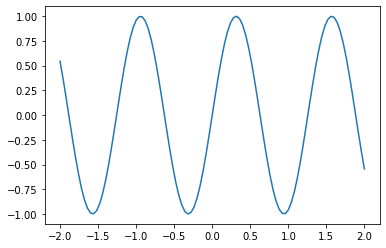

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

curve_data = np.load('data/curve_data1.npz')
points = curve_data['points']
normals = curve_data['normals']

plt.plot(points[:,0], points[:,1])

### Answer

In [27]:
import numpy as np
from scipy.spatial import distance_matrix


def CalC0(X_mat, Xi_mat, Ni, sigma):
    # X_mat     n x d matrix    n is # of grid points, d is dimension
    # Xi_mat    m x d matrix    m is # of sample points, d is dimension 
    # Ni        m x d matrix    m is # of sample points, d is dimension 
    # C0        n x 1 vector    n is # of grid points

    C0 = np.zeros((X_mat.shape[0], 1))

    for idx in range(X_mat.shape[0]):
        #  idx is index of grid point (x, y)

        X = X_mat[idx, :].reshape(1, -1) # grid (x, y)
        
        # Ni: column j = (njx, njy)
        # 1xm
        sqd_X_Xi = distance_matrix(X, Xi_mat) ** 2  # column j = squared_euc_dist(x, xj)
        
        # dxm
        X_Xi = (X - Xi_mat).T                             # column j = (x - xj, y - yj)

        # phi_i(x) = exp(...)
        # 1xm
        phi_i = np.exp(-sqd_X_Xi / (sigma ** 2))

        # sum(ni' * (X - Xi) * exp(...))
        # 1
        nom = np.sum(
            np.sum(Ni.T * X_Xi, 0) * phi_i
            )

        # sum(exp(...))
        # 1
        denom = np.sum(phi_i)
        C0[idx][0] = nom / denom
    
    return C0

def Fx2D(Xi_mat, Ni, x_range, y_range, sigma):
    #FX2D calculate F(x) = C0(x) for 2D point x


    x_gr, y_gr = np.meshgrid(x_range, y_range)
    x_gr = x_gr.reshape(-1, 1)
    y_gr = y_gr.reshape(-1, 1)

    X_mat = np.concatenate([x_gr, y_gr], 1)
    C0 = CalC0(X_mat, Xi_mat, Ni, sigma)

    # C0 
    # (-2, -2) | (2, -2)
    # (-2, 2)  | (2, 2)
    C0 = C0.reshape(y_range.shape[0], x_range.shape[0])

    return C0[::-1,:]


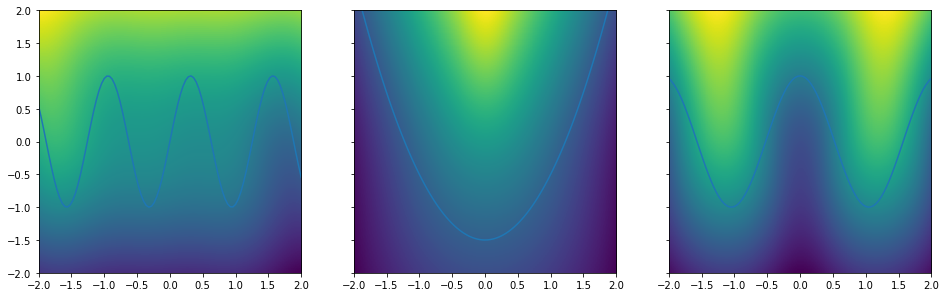

In [39]:
import numpy as  np
from matplotlib import pyplot as plt


def main():
    x_min = -2     
    x_max = 2     
    y_min = -2    
    y_max = 2

    delta_x = 0.01
    delta_y = 0.01

    x_range = np.arange(x_min, x_max, delta_x).reshape(-1,1)
    y_range = np.arange(y_min, y_max, delta_y).reshape(-1,1)

    curve_1 = np.load('data/curve_data1.npz')
    curve_2 = np.load('data/curve_data2.npz')
    curve_3 = np.load('data/curve_data3.npz')

    curves = [curve_1, curve_2, curve_3]

    sigma = 1

    C0s = []
    points_ls = []

    for i, curve in enumerate(curves):
        Xi_mat = curve['points']
        points_ls.append(Xi_mat)
        Ni = curve['normals']
        C0 = Fx2D(Xi_mat, Ni, x_range, y_range, sigma)
        C0s.append(C0)
    
    # plot
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all')
    f.set_size_inches((16,12))
    ax1.imshow(C0s[0], interpolation='none', extent=(-2, 2, -2, 2))
    ax1.plot(points_ls[0][:,0], points_ls[0][:,1])
    plt.axis([-2, 2, -2, 2])

    ax2.imshow(C0s[1], interpolation='none', extent=(-2, 2, -2, 2))
    ax2.plot(points_ls[1][:,0], points_ls[1][:,1])
    plt.axis([-2, 2, -2, 2])

    ax3.imshow(C0s[2], interpolation='none', extent=(-2, 2, -2, 2))
    ax3.plot(points_ls[2][:,0], points_ls[2][:,1])
    plt.axis([-2, 2, -2, 2])
 
if __name__ == '__main__' :
    main()

### **Results**



> $\sigma=1$

![](https://drive.google.com/uc?export=view&id=1It6z8lrDZQVECMwFzOlNb-kfRN0SbVr2)

> $\sigma=0.5$

![](https://drive.google.com/uc?export=view&id=1AseOza9Ubm6Q6KJWprbNsJxZy0o0yGHj)

> $\sigma=0.1$

![](https://drive.google.com/uc?export=view&id=1zN011NVFicXrB9eCRB2XTVHHM23GOqwC)

> $\sigma=0.05$

![](https://drive.google.com/uc?export=view&id=1cinYzc-UVy2FtMQgqGSZbZKpjIX6z-4l)

> $\sigma=0.01$

![](https://drive.google.com/uc?export=view&id=1L1Y7yrdBqntGVF2h9IWIwX8JXOZJua1M)

> $\sigma=0.001$

![](https://drive.google.com/uc?export=view&id=1rxU6nv0Ni9BWSJ0Vdd1edT5uRCbSZGf6)



### **Discussion**

The choice of $\sigma$-value for Gaussian weighting function will affect the size of the moving window when the grid resolution is fixed at 0.01 in both axes. Thus, when $\sigma$-value is too small, the size of the moving window will not be large enough to generate a proper curve. Whereas when $\sigma$-value is too large, the curve will not fit the sample points well enough. Thus, there exists a balance between the continuity and smoothness of the curve when it comes to choosing the $\sigma$-value. According to the results above, it is achieved at approximately $\sigma=0.1$.

### Smoothing meshes

Load the vertices and normals of the provided meshes. These will serve as the sample points and normals. Then, project each vertex coordinate $\mathbf{v}$ of the mesh by $\mathbf{v}′ = \mathbf{v} − f(\mathbf{x})\nabla f(\mathbf{x})$, where $f(\mathbf{x})$ is the same as in the first task. This will give you new smoothed coordinates $\mathbf{v}′$ of the mesh vertices. The expression for $\nabla f(\mathbf{x})$ can be derived on paper - use the chain rule, the result is a long formula :). The answer is not the same as the one in the attached paper (but part of it is similar). Apply this smoothing a few times, obtaining a result similar to this

![](https://drive.google.com/uc?export=view&id=1lvzTIdvNWA8aj0kC83aApfx6SWgoyp00)

To load, modify and display meshes, you can use the `trimesh` package (`pip install --user trimesh`). Here's a quick example to load and visualize the stanford bunny mesh 

In [40]:
!pip install --user trimesh

In [42]:
import trimesh
import numpy as np

In [75]:
# To load a mesh
mesh = trimesh.load_mesh('data/cat.off', process=False)

# To access the vertices, faces and normals
vertices = mesh.vertices
faces = mesh.faces
normals = mesh.vertex_normals

# To visualize a mesh
mesh.show()

#### Hints

* The expression for $\nabla f(\mathbf{x})$ can be easily derived on paper. If you wish, you may confirm your expression by comparing it to the expression in Section 4.3 of the paper "Feature Preserving Point Set Surfaces based on Non-Linear Kernel Regression" provided next to this notebook.
* The function $f(\mathbf{x})$ is always computed by using the initial positions and normals of the vertices, even if you do multiple iterations of projections.
* As in the previous exercise, try changing $\sigma$ to see its smoothing effect.

#### Required outputs

* **The derivation of $\nabla f(\mathbf{x})$**
* **The mesh smoothing code**
* **Screenshots of results produced by your code for both meshes**

### Answer - derivation


$$\nabla f(\mathbf{x})=\nabla \frac{\sum_i\phi_i(\mathbf{x})f_i(\mathbf{x})}{\sum_i\phi_i(\mathbf{x})}=\nabla \frac{\sum_i\phi_i(\mathbf{x})\mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})}{\sum_i\phi_i(\mathbf{x})}$$
Thus
$$
\nabla f(\mathbf{x})=\frac{\nabla(\sum_i\phi_i(\mathbf{x})\mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i}))(\sum_i\phi_i(\mathbf{x}))-(\sum_i\phi_i(\mathbf{x})\mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i}))\nabla(\sum_i\phi_i(\mathbf{x}))}{(\sum_i\phi_i(\mathbf{x}))^2}
$$
Simplify
$$
\nabla f(\mathbf{x})= \frac{\sum_i\nabla(\phi_i(\mathbf{x}))\mathbf{n_i}^T\mathbf{x}+\sum_i\phi_i(\mathbf{x})\mathbf{n_i}^T-\sum_i\nabla(\phi_i(\mathbf{x}))\mathbf{n_i}^T\mathbf{x_i}-\frac{\sum_i\phi_i(\mathbf{x})\mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})}{\sum_i\phi_i(\mathbf{x})}(\sum_i\nabla\phi_i(\mathbf{x}))}{\sum_i\phi_i(\mathbf{x})}
$$
Thus
$$
\nabla f(\mathbf{x})=\frac{\sum_i\phi_i(\mathbf{x})\mathbf{n_i}+\sum_i[\mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})-f(\mathbf{x})]\nabla\phi_i(\mathbf{x})}{\sum_i\phi_i(\mathbf{x})}
$$

### Answer - smoothing code

In [44]:
# write your answer here

def Fx3D(X_mat, V_mat, N_mat, sigma):
    #FX3D calculate F(x) = C0(x) for 3D point x
    
    # X_mat     n x 3 matrix    grid points
    # V_mat     m x 3 matrix    sampe points 
    # N_mat     m x 3 matrix    normal vectors (samples)

    # gradFx  3 x n 
    gradFx_mat = np.zeros((3, X_mat.shape[0]))
    
    # calculate C0 first 
    # 3xn
    Fx_mat = np.zeros((3, X_mat.shape[0]))

    # range(n)
    for idx in range(X_mat.shape[0]):
        # idx is index of given point x = (x1, x2, x3)
        
        # 1x3
        X = X_mat[idx, :].reshape(1, -1)  # x = (x1, x2, x3)

        # vertex point v = (v1, v2, v3)
        # 3xm
        Ni = N_mat.T
        # 1xm                                        # column j: (nj1, nj2, nj3)'
        sqd_X_Xi = distance_matrix(X, V_mat)  ** 2   #column j: squared_euc_dist(x, vj)
        # 3xm
        X_Xi = (X - V_mat).T                         # column j: (x1 - vj1, x2 - vj2, x3 - vj3)'
        
        # phi_i(x) = exp(...)
        # 1xm
        phi_i = np.exp(-sqd_X_Xi / (sigma ** 2))

        # grad_phi_i(x)
        # 3xm
        grad_phi_i = (-2 / sigma ** 2) * phi_i * X_Xi

        # cal Fx 
        # 1
        nomFx = np.sum(
            np.sum(Ni * X_Xi, 0) * phi_i
            )
        
        # 1
        Fx = nomFx / np.sum(phi_i)

        Fx_mat[:, idx] = Fx

        # cal Grad Fx
        # 3x1
        nomGradFx = np.sum(
            (Ni * phi_i) + ((np.sum(Ni * X_Xi, 0) - Fx) * grad_phi_i), 
            1
            )
        
        gradFx_mat[:, idx] = nomGradFx / np.sum(phi_i)
    
    FxGradFx = Fx_mat * gradFx_mat
    # FxGradFx  n x 3
    FxGradFx = FxGradFx.T 

    return FxGradFx



In [74]:
import trimesh
import numpy as np 

max_iter = 5

sigma = 100

mesh = trimesh.load_mesh('data/bunny.off', process=False)

# To access the vertices, faces and normals
vertices = mesh.vertices
faces = mesh.faces
normals = mesh.vertex_normals

V = np.array(vertices)

for _ in range(max_iter):
    FxGradFx = Fx3D(np.array(vertices), V, np.array(normals), sigma)
    V = V - FxGradFx

mesh.vertices = V
mesh.show()

In [85]:
max_iter = 5

sigma = 30

mesh = trimesh.load_mesh('data/cat.off', process=False)

# To access the vertices, faces and normals
vertices = mesh.vertices
faces = mesh.faces
normals = mesh.vertex_normals

V = np.array(vertices)

for _ in range(max_iter):
    FxGradFx = Fx3D(np.array(vertices), V, np.array(normals), sigma)
    V = V - FxGradFx

mesh.vertices = V
mesh.show()